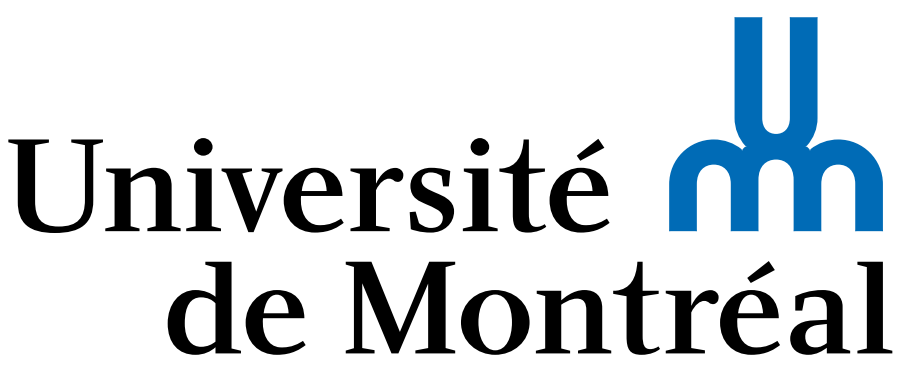

# IFT6285 (TALN) 

## Devoir 2: Modèles n-grammes avec kenlm

Réalisé par:

Mouna Dhaouadi 

Kacem Khaled

Soumis à:

Prof. Philippe Langlais

Frédéric Piedboeuf


**Automne 2021**

In [69]:
pip install https://github.com/kpu/kenlm/archive/master.zip

  Using cached https://github.com/kpu/kenlm/archive/master.zip
  Created wheel for kenlm: filename=kenlm-0.0.0-cp38-cp38-linux_x86_64.whl size=2972490 sha256=7f6a07842e227a813e0e7faa0a33bd607ab0f1d5bb280fb3b8ddfe880f3ef65d
  Stored in directory: /tmp/pip-ephem-wheel-cache-01qdq0ys/wheels/ff/08/4e/a3ddc0e786e0f3c1fcd2e7a82c4324c02fc3ae2638471406d2
Successfully built kenlm
Note: you may need to restart the kernel to use updated packages.


In [84]:
import kenlm
import time
from tqdm import tqdm
import os
from os import listdir
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean, stdev

In [2]:
folder = 'training-monolingual.tokenized.shuffled/'
folder_short = '1bshort/'
folder_test = 'heldout-monolingual.tokenized.shuffled/'
kenlm_dir = '/home/kacem/kenlm/' 
test_file = folder_test+'news.en-00000-of-00100'
model_file = 'models/bigram'

In [3]:
# make sure we are in the right directory 
a  = subprocess.run('pwd',  capture_output=True,text=True)
print(a.stdout)

/mnt/c/Users/kacem/Workspace/IFT6285/github-nlp/IFT6285-NLP/TP2



In [113]:
def test(model_file, test_file):
    model = kenlm.Model(model_file)
    perplex = []
    i=0
    with open(test_file, 'r',encoding="utf8") as f:
        while i < 1000:
            line = f.readline()
            perplex.append(model.perplexity(line))
            i+=1
    f.close()
    return perplex

In [114]:
def train(model_file, folder,test_file, order=2):
    files = listdir(folder)
    times = []
    sizes = []
    perplexities = []
    start_time = time.time()
    fns = ""
    
    for i,fn in enumerate(files):
        model_file_name = model_file +str(i+1)+'.arpa'
        training_sample = "models/training_sample.txt"
        # comcatenate the first {0..i} text files and use them all for training
        # this would help check the impact of training data size
        fns += folder+fn+' '
        os.system("cat "+fns+ " > "+ training_sample)
        print(f"Files 1..{i+1}:")
        #print(fns)
        cmd = kenlm_dir+'build/bin/lmplz -o '+str(order)+' -S 80% -T /tmp < '+training_sample+' > '+model_file_name
        #print(cmd, end='\n\n')
        os.system(cmd)
        t = time.time() - start_time
        size = os.path.getsize(model_file_name) / (1024*1024) # convert to MB
        perp = test(model_file_name,test_file)
        times.append(t)
        sizes.append(size)
        perplexities.append(perp)
        print(f'Time: {t:.2f}s\t Size: {size:.2f}MB\t Mean(perplexities): {mean(perp):.2f}')
    return times, sizes, perplexities

In [115]:
model_file = 'models/bigram'
times_bi, sizes_bi, perplexities_bi = train(model_file,folder_short,test_file,2)

Files 1..1:
Time: 5.49s	 Size: 52.29MB	 Mean(perplexities): 519.21
Files 1..2:
Time: 16.96s	 Size: 85.39MB	 Mean(perplexities): 459.77
Files 1..3:
Time: 34.33s	 Size: 112.84MB	 Mean(perplexities): 452.84
Files 1..4:
Time: 57.21s	 Size: 137.61MB	 Mean(perplexities): 445.56
Files 1..5:
Time: 85.18s	 Size: 160.58MB	 Mean(perplexities): 433.43
Files 1..6:
Time: 118.42s	 Size: 181.73MB	 Mean(perplexities): 432.02
Files 1..7:
Time: 155.66s	 Size: 201.99MB	 Mean(perplexities): 418.99
Files 1..8:
Time: 198.66s	 Size: 220.77MB	 Mean(perplexities): 416.19
Files 1..9:
Time: 246.60s	 Size: 239.24MB	 Mean(perplexities): 412.93


In [148]:
len(perplexities_bi[0])
min_p = [min(p) for p in perplexities_bi]
max_p = [max(p) for p in perplexities_bi]
avg_p = [mean(p) for p in perplexities_bi]

In [165]:
def plot_curves(times_bi, sizes_bi, perplexities_bi):
    avg_p = [mean(p) for p in perplexities_bi]
    tranches = list(range(1,10))
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(tranches, sizes_bi  , 'g-', label="Taille (MB)")
    ax.set_xlabel("Nombre de tranches considérées")
    ax.set_ylabel("Taille de modèle (MB) | Temps d'entrainement (s)")

    ax.plot(tranches, times_bi,'r-', label="Temps (s)")
    #ax.set_ylabel("Le temps mis pour l'entrainement (en secondes)", color = 'r')

    ax2=ax.twinx()

    ax2.plot(tranches, avg_p,'b-', label="Moyennes perplexité")
    ax2.set_xlabel("Nombre de tranches considérées")
    ax2.set_ylabel("Moyenne des perplexités", color = 'b')

    ax.set_xlim(1, 9)
    #ax.set_ylim(0, 300)
    #ax2.set_ylim(400, 550)

    ax.legend(loc=2)
    ax2.legend(loc=1)

    plt.show()

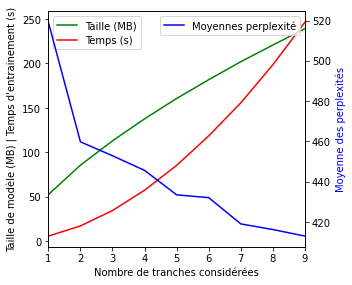

In [166]:
plot_curves(times_bi, sizes_bi, perplexities_bi)

In [126]:
d = {'Tranches': tranches, 'Tailles des modèles (MB)': sizes, 'Temps d\'entrainement (s)': times }
df_results = pd.DataFrame(data=d, index = list(range(1,10)))
df_results.style.format(formatter={('Tranches'): "{:d}",
                           ( 'Tailles des modèles (MB)'):"{:.2f}" ,
                           ( 'Temps d\'entrainement (s)'):"{:.2f}" 
                          })

,Tranches,Tailles des modèles (MB),Temps d'entrainement (s)
1,1,207.08,10.38
2,2,366.06,37.82
3,3,505.30,79.52
4,4,639.00,134.38
5,5,761.69,201.40
6,6,867.39,281.47
7,7,984.80,371.77
8,8,1092.33,476.14
9,9,1189.10,597.76


In [127]:
df_results.T

,1,2,3,4,5,6,7,8,9
Tranches,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
Tailles des modèles (MB),207.078398,366.058455,505.295388,638.999955,761.693218,867.386126,984.801415,1092.329220,1189.097574
Temps d'entrainement (s),10.377470,37.822441,79.515985,134.377091,201.398867,281.470361,371.765788,476.141532,597.757107


In [129]:
perplexities = test('models/bigram9.arpa',test_file)

In [133]:
len(perplexities)

1000

In [132]:
print(f"Mean:\t{mean(perplexities)}\nMax:\t{max(perplexities)}\nMin:\t{min(perplexities)}")


Mean:	412.9330384934711
Max:	21411.129542915227
Min:	28.735341750242814


In [131]:
# test 3-gramme
model_file = 'models/trigram'
times_tr, sizes_tr, perplexities_tr = train(model_file,folder_short,test_file,3)

Files 1..1:
Time: 10.05s	 Size: 207.08MB	 Mean(perplexities): 448.98
Files 1..2:
Time: 37.56s	 Size: 366.06MB	 Mean(perplexities): 387.92
Files 1..3:
Time: 79.47s	 Size: 505.30MB	 Mean(perplexities): 375.11
Files 1..4:
Time: 133.49s	 Size: 639.00MB	 Mean(perplexities): 361.66
Files 1..5:
Time: 200.27s	 Size: 761.69MB	 Mean(perplexities): 347.82
Files 1..6:
Time: 279.40s	 Size: 867.39MB	 Mean(perplexities): 343.11
Files 1..7:
Time: 371.33s	 Size: 984.80MB	 Mean(perplexities): 328.55
Files 1..8:
Time: 475.13s	 Size: 1092.33MB	 Mean(perplexities): 321.91
Files 1..9:
Time: 590.22s	 Size: 1189.10MB	 Mean(perplexities): 317.59


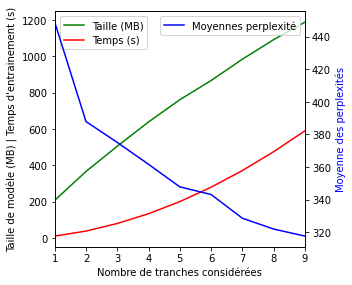

In [167]:
plot_curves(times_tr, sizes_tr, perplexities_tr)